In [1]:
import sys; sys.path.append('..')
from typing import List

from pydantic import BaseModel, Field

from brain.sdk import BrainClient

In [2]:
brain_client = BrainClient("http://127.0.0.1:8000")

In [3]:
# Global mock data
_MOCK_DATA = {
    "products": [
        {"category": "fitness", "name": "Fitness Tracker A", "price": 80.0, "rating": 4.3},
        {"category": "fitness", "name": "Yoga Mat Pro", "price": 50.0, "rating": 4.0},
        {"category": "gadgets", "name": "Smartwatch X", "price": 200.0, "rating": 4.7},
        {"category": "gadgets", "name": "Noise-Cancelling Headphones", "price": 150.0, "rating": 4.6},
        {"category": "home", "name": "Vacuum Cleaner Z", "price": 120.0, "rating": 4.1},  # Irrelevant
        {"category": "home", "name": "Air Purifier", "price": 130.0, "rating": 4.4},  # Irrelevant
    ],
    "reviews": {
        "Fitness Tracker A": ["Great for tracking steps", "Affordable and durable", "Battery life could be better"],
        "Yoga Mat Pro": ["Good grip", "Too thin for comfort", "Easy to clean"],
        "Smartwatch X": ["Amazing features", "Sleek design", "Pricey but worth it"],
        "Noise-Cancelling Headphones": ["Great sound quality", "Perfect for travel", "Comfortable for long use"],
    }
}


In [4]:
class ProfileAnalysis(BaseModel):
    categories: List[str] = Field(..., description="The list of product categories the user is interested in.")
    budget: str = Field(..., description="The user's budget preference, e.g., 'low', 'mid', 'high'.")
    preferred_brands: List[str] = Field(..., description="List of user's preferred brands.")


@brain_client.reasoner(schema=ProfileAnalysis)
def profile_analyzer(profile: dict):
    categories = profile.get("interests", [])
    budget = profile.get("budget", "mid-range")
    preferred_brands = profile.get("preferred_brands", [])

    if not categories:
        categories = ["general"]

    return (
        f"User profile: categories={categories}, budget={budget}, preferred_brands={preferred_brands}",
        "Analyze the user's profile and extract categories, budget, and brand preferences."
    )
profile_analyzer_id = profile_analyzer.register()

In [5]:
class Product(BaseModel):
    name: str = Field(..., description="The name of the product.")
    price: float = Field(..., description="The price of the product.")
    rating: float = Field(..., description="The rating of the product out of 5.")

class TrendingProducts(BaseModel):
    category: str = Field(..., description="The product category.")
    products: List[Product] = Field(..., description="List of trending products in this category.")


@brain_client.reasoner(schema=TrendingProducts)
def trend_detector(categories: List[str], budget: str):
    budget_range = {
        "low": (0, 100),
        "mid": (101, 200),
        "high": (201, 500),
    }

    min_price, max_price = budget_range.get(budget, (0, 500))

    # Filter mock data for relevant products
    relevant_products = [
        Product(name=p["name"], price=p["price"], rating=p["rating"])
        for p in _MOCK_DATA["products"]
        if p["category"] in categories and min_price <= p["price"] <= max_price
    ]

    return (
        f"Relevant products: {relevant_products}",
        f"Find trending products in categories={categories} within budget={budget}."
    )
trend_detector_id = trend_detector.register()

In [6]:
# %%
class RankedProduct(BaseModel):
    name: str = Field(..., description="The name of the product.")
    rank_score: float = Field(..., description="The ranking score of the product.")
    availability: bool = Field(..., description="Whether the product is in stock.")

class RankedProducts(BaseModel):
    products: List[RankedProduct] = Field(..., description="List of ranked products.")


@brain_client.reasoner(schema=RankedProducts)
def product_ranker(products: List[Product], preferences: ProfileAnalysis):
    # Add scoring logic based on rating and availability
    ranked = [
        RankedProduct(name=product.name, rank_score=product.rating * 10, availability=True)
        for product in products
    ]
    return (
        f"Ranked products: {ranked}",
        "Rank products based on user preferences, rating, and availability."
    )
product_ranker_id = product_ranker.register()

In [7]:
class ReviewSummary(BaseModel):
    product_name: str = Field(..., description="The name of the product.")
    review_points: List[str] = Field(..., description="Key points from customer reviews.")
    sentiment: str = Field(..., description="The overall sentiment of reviews (positive, neutral, negative).")


@brain_client.reasoner(schema=ReviewSummary)
def review_summarizer(product: RankedProduct):
    # Fetch reviews from mock data
    reviews = _MOCK_DATA["reviews"].get(product.name, ["No reviews available"])
    sentiment = "positive" if len(reviews) > 2 else "neutral"

    return (
        f"Summarized reviews for {product.name}",
        f"Summarize reviews for the product {product.name}, analyzing sentiment={sentiment}."
    )
review_summarizer_id = review_summarizer.register()

In [8]:
class FinalRecommendation(BaseModel):
    product_name: str = Field(..., description="The name of the recommended product.")
    reason: str = Field(..., description="The reasoning behind this recommendation.")

class FinalRecommendations(BaseModel):
    recommendations: List[FinalRecommendation] = Field(..., description="List of final recommendations.")


@brain_client.reasoner(schema=FinalRecommendations)
def recommendation_generator(ranked_products: List[RankedProduct], reviews: List[ReviewSummary]):
    recommendations = [
        FinalRecommendation(
            product_name=product.name,
            reason=f"{product.name} is highly rated with {review.sentiment} reviews."
        )
        for product, review in zip(ranked_products, reviews)
    ]
    return (
        f"Final recommendations: {recommendations}",
        "Generate actionable recommendations based on ranked products and reviews."
    )
recommendation_generator_id = recommendation_generator.register()

In [9]:
@brain_client.multi_agent
def generate_recommendations(profile: dict):
    # Step 1: Analyze the user profile
    profile_analysis = brain_client.use(profile_analyzer_id)(profile=profile)

    # Step 2: Find trending products for user preferences
    trending_data = brain_client.use(trend_detector_id)(
        categories=profile_analysis.categories, budget=profile_analysis.budget
    )

    # Step 3: Rank the products
    ranked_products = brain_client.use(product_ranker_id)(
        products=trending_data.products, preferences=profile_analysis
    )

    # Step 4: Summarize reviews for the top-ranked products
    review_summaries = [
        brain_client.use(review_summarizer_id)(product=product)
        for product in ranked_products.products[:3]
    ]

    # Step 5: Generate final recommendations
    final_recommendations = brain_client.use(recommendation_generator_id)(
        ranked_products=ranked_products.products, reviews=review_summaries
    )

    return final_recommendations

In [10]:
profile = {
    "age": 29,
    "interests": ["fitness", "gadgets"],
    "budget": "mid",
    "preferred_brands": ["Apple", "Nike"]
}

result = generate_recommendations(profile)
from rich import print
print(result)

FinalRecommendations(
    recommendations=[
        FinalRecommendation(
            product_name='Smartwatch X',
            reason='Smartwatch X is highly rated with positive reviews, indicating high customer satisfaction and 
reliability.'
        )
    ]
)

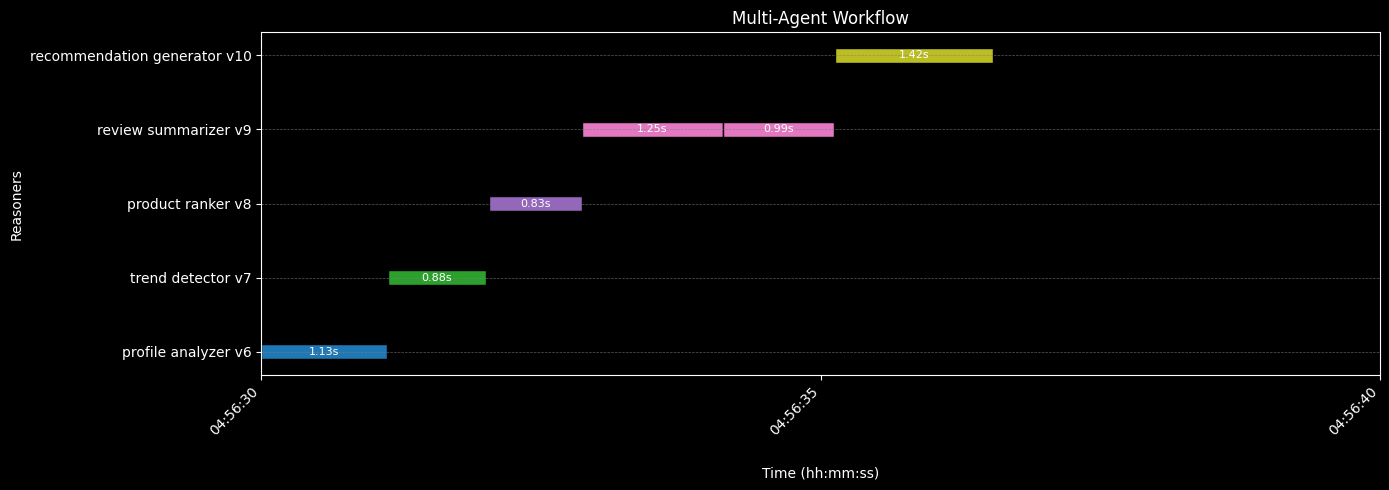

In [11]:
from brain.visualize import plot_workflow_matplotlib
lineage = brain_client.get_call_graph("c9babec6-da69-4395-927e-feaddf97b556")
fig=plot_workflow_matplotlib(lineage['lineage'])